In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import mlflow
os.environ['MLFLOW_TRACKING_URI'] = './mlruns'
mlflow.set_tracking_uri(os.environ.get('MLFLOW_TRACKING_URI'))

## 1

<img src='./images/01.png' width=800>

In [4]:
mlflow.set_experiment('Exercise_1')

2025/04/08 16:56:44 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_03/mlruns/977541838521498000', creation_time=1744118804165, experiment_id='977541838521498000', last_update_time=1744118804165, lifecycle_stage='active', name='Exercise_1', tags={}>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.optim as optim
from utils import (train_network, roc_auc_score_micro_wrapper, 
                accuracy_score_wrapper,f1_score_wrapper,
                weight_reset, set_seed)
from models import model_linear, model_cnn, model_cnn_pool
from torchinfo import summary


In [ ]:
mnist_data_train = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    )
mnist_data_test = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
    )

batch_size = 32
mnist_train_loader = DataLoader(
    mnist_data_train,
    batch_size=batch_size,
    shuffle=True
    )
mnist_test_loader = DataLoader(
    mnist_data_test,
    batch_size=batch_size
    )

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.RandomAffine(
            degrees=5,
            translate=(0.05, 0.05),
            scale=(0.98, 1.02),
            ),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.ToTensor()
mnist_train_augmented = torchvision.datasets.MNIST(
    './data_augmented',
    train=True,
    transform=train_transforms,
)
mnist_test_augmented = torchvision.datasets.MNIST(
    './data_augmented',
    train=False,
    transform=test_transforms,
)

batch_size=16
mnist_train_augmented_loader = DataLoader(
    mnist_train_augmented,
    shuffle=True,
    batch_size=batch_size,
    num_workers=5
    )
mnist_test_augmented_loader = DataLoader(
    mnist_test_augmented,
    batch_size=batch_size,
    num_workers=5
    )

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD
loss_func = nn.CrossEntropyLoss()
score_funcs = {"Accuracy": accuracy_score_wrapper}
epochs = 40
params = {
    'device': device,
    'loss_func': loss_func.__class__.__name__,
    'epochs': epochs
}
def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid Acc', label='valid Acc')
    plt.xlabel('epoch')
    plt.ylabel('valid Acc')
    plt.title('valid Acc')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

In [ ]:

models = (model_linear, model_cnn, model_cnn_pool, model_cnn_pool)
train_loaders = (mnist_train_loader, mnist_train_loader, mnist_train_loader, mnist_train_augmented_loader)
test_loaders = (mnist_test_loader, mnist_test_loader, mnist_test_loader, mnist_test_augmented_loader)
name_experiment = (
    'linear_mnist',
    'cnn_mnist',
    'cnn_pool_mnist',
    'cnn_pool_augmented_mnist'
)

In [ ]:
for i in range(4):
    model = models[i]
    train_loader = train_loaders[i]
    test_loader = test_loaders[i]
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    params['optimizer'] = optimizer.defaults
    
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    with mlflow.start_run(nested=True, run_name=name_experiment[i]):
        mlflow.log_params(params)
        mlflow.log_artifact('model_summary_txt')
        results = train_network(
            model=model,
            optimizer=optimizer,
            loss_func=loss_func,
            train_loader=mnist_train_loader,
            val_loader=mnist_test_loader,
            epochs=epochs,
            device=device,
            score_funcs=score_funcs,
            )

In [ ]:
cnn_results = train_network(
    model=model_cnn,
    optimizer=optimizer,
    loss_func=loss_func,
    train_loader=mnist_train_loader,
    val_loader=mnist_test_loader,
    epochs=40,
    device=device,
    score_funcs=score_funcs,
)

In [ ]:
cnn_with_pool_results = train_network(
    model=model_cnn_pool,
    optimizer=optimizer,
    loss_func=loss_func,
    train_loader=mnist_train_loader,
    val_loader=mnist_test_loader,
    epochs=40,
    device=device,
    score_funcs=score_funcs,
)

In [ ]:

cnn_with_pool_augmentation_results = train_network(
    model=model_cnn_pool,
    optimizer=optimizer,
    loss_func=loss_func,
    train_loader=mnist_train_augmented_loader,
    val_loader=mnist_test_augmented_loader,
    epochs=40,
    device=device,
    score_funcs=score_funcs,
)

## 2

<img src='./images/02.png' width=800>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
import torchvision
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score
from utils import train_network

/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_03/utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
cifar_train = torchvision.datasets.CIFAR10(
    './data_cifar',
    download=True,
    transform=transforms.ToTensor(),
    train=True,)
cifar_test = torchvision.datasets.CIFAR10(
    './data_cifar',
    download=True,
    transform=transforms.ToTensor(),
    train=False,)

In [ ]:
batch_size = 16
cifar_train_loader = DataLoader(
    cifar_train,
    shuffle=True,
    batch_size=batch_size,
    num_workers=5)

cifar_train_loader = DataLoader(
    cifar_test,
    batch_size=batch_size,
    num_workers=5)

In [21]:
# C = cifar_train[0][0].shape[0]
C = 3
filter = 16
K = 3
# w = cifar_train[0][0].shape[1]
# h = cifar_train[0][0].shape[2]
w , h = 32, 32
# classes = cifar_train[0][1].shape[0]
classes = 10
def build_model(num_conv_layers, num_pool_layers):
    layers =[]
    in_channels = C
    out_channels = 16
    if num_pool_layers:
        pool_interval = max(1, num_conv_layers // (num_pool_layers + 1))
    else:
        pool_interval = num_conv_layers + 1
    
    currnet_pool_rounds = 0
    for i in range(num_conv_layers):
        layers.append(nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size=3,
            padding=3//2))
        layers.append(nn.ReLU(inplace=True))
        in_channels = out_channels
        if (i+1) % pool_interval == 0 and currnet_pool_rounds < num_pool_layers:
            layers.append(nn.MaxPool2d(kernel_size=2))
            currnet_pool_rounds += 1
            out_channels *= 2
    final_w = w // (2 ** num_pool_layers)
    final_h = h // (2 ** num_pool_layers)
    classifier  = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_channels * final_w * final_h ,classes),
        )
    model = nn.Sequential(*layers, classifier)
    return model

In [22]:
from torchinfo import summary
summary(build_model(20, 2), input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           448
├─ReLU: 1-2                              [1, 16, 32, 32]           --
├─Conv2d: 1-3                            [1, 16, 32, 32]           2,320
├─ReLU: 1-4                              [1, 16, 32, 32]           --
├─Conv2d: 1-5                            [1, 16, 32, 32]           2,320
├─ReLU: 1-6                              [1, 16, 32, 32]           --
├─Conv2d: 1-7                            [1, 16, 32, 32]           2,320
├─ReLU: 1-8                              [1, 16, 32, 32]           --
├─Conv2d: 1-9                            [1, 16, 32, 32]           2,320
├─ReLU: 1-10                             [1, 16, 32, 32]           --
├─Conv2d: 1-11                           [1, 16, 32, 32]           2,320
├─ReLU: 1-12                             [1, 16, 32, 32]           --

In [16]:
for i in range(2, 21):
    for j in range(3):
        print(f'model{i}_{j}')
        print(build_model(i, j))

model2_0
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=10, bias=True)
  )
)
model2_1
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=10, bias=True)
  )
)
model2_2
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD
loss_func = nn.CrossEntropyLoss()
def accuracy_score_wrapper(y_pred, y_true):
    if y_pred.ndim >=2:
        pred = np.argmax(y_pred, axis=1)
    return accuracy_score(pred, y_true)
score_funcs = {"Accuracy": accuracy_score_wrapper}

In [ ]:
for num_conv in range(2, 21):
    for num_pool in range(0,3):      
        model = build_model(num_conv, num_pool)
        results = train_better_network(
        model=model,
        optimizer=optimizer,
        loss_func=loss_func,
        train_loader=mnist_train_loader,
        val_loader=mnist_test_loader,
        epochs=10,
        device=device,
        score_funcs=score_funcs,
        )

## 3

<img src='./images/03.png' width=800>

In [7]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
import torchvision
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score
from utils import train_network

In [8]:
cifar_train = torchvision.datasets.CIFAR10(
    './data_cifar',
    download=True,
    transform=transforms.ToTensor(),
    train=True,)
cifar_test = torchvision.datasets.CIFAR10(
    './data_cifar',
    download=True,
    transform=transforms.ToTensor(),
    train=False,)

100%|██████████| 170498071/170498071 [01:43<00:00, 1649770.03it/s]


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar
Files already downloaded and verified


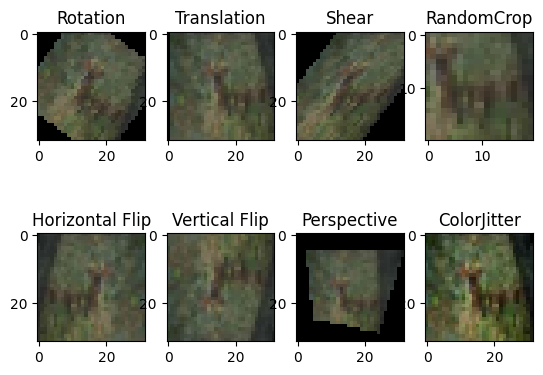

In [33]:
import matplotlib.pyplot as plt
img = cifar_train[10][0]
#Several built-in transformations, given some agressive values to make their impact more obvious.  
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),   
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img))
    axarr[col,row].set_title(name)
plt.show()

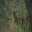

In [25]:
img_pil = transforms.ToPILImage()(img)
img_pil.show()

## 4

<img src='./images/04.png' width=800>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
import torchvision
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score
from utils import train_better_network
from models import model_linear, model_cnn, model_cnn_pool

In [ ]:
train_transforms = transforms.Compose(
    [
        # transforms.RandomAffine(degrees=10),
        transforms.RandomAffine(degrees=5, translate=(0.05,0.05), shear=10),
        # transforms.RandomAffine(degrees=0, shear=45),
        transforms.RandomHorizontalFlip(p=.2),
        # transforms.RandomVerticalFlip(p=1.0),
        transforms.RandomPerspective(distortion_scale=0.2, p=.2),   
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.ToTensor()

In [ ]:
cifar_train = torchvision.datasets.CIFAR10(
    './data_augmented_cifar',
    download=True,
    transform=train_transforms,
    train=True,)
cifar_test = torchvision.datasets.CIFAR10(
    './data_augmented_cifar',
    download=True,
    transform=test_transforms,
    train=False,)

In [ ]:
batch_size = 256
cifar_train_loader = DataLoader(
    cifar_train,
    shuffle=True,
    batch_size=batch_size,)

cifar_train_loader = DataLoader(
    cifar_test,
    batch_size=batch_size)

## 5

<img src='./images/05.png' width=800>

## 6

<img src='./images/06.png' width=800>